# Implementación de un modelo de deep learning.
## Cutberto Arizabalo Nava A01411431

En este notebook realicé la implementación de un modelo de reconocimiento de imágenes utilizando técnicas de deep learning.

El objetivo de este modelo es identificar entre 10 tipos diferentes de monos con una precisión mínima del 70%. Para lograrlo se utilizará el framework TensorFlow, el cuál está enfocado a aplicaciones de Machine Learning en Python.

In [7]:
#Importamos las librerías necesarias
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Para entrenar el modelo, se cuenta con un dataset de aprox. 1300 imagenes de monos etiquetadas de acuerdo al tipo de macaco que sea. 

## Primer modelo

Como paso inicial, vamos a cargar las imagenes de entrenamiento y validación. Para esto, me apoyo de la herramienta de preprocesado ImageDataGenerator, ya que me esto me permitirá definir valores como el espectro de colores, el tamaño de la imagen y el tipo de clases a guardar (binario o múltiple).

 En este caso, seleccionar sparse permitrá que la herramienta detecte las diferentes clases existentes (10 en este caso).

In [13]:
# Genero un image data generator vanilla
datagen = ImageDataGenerator()

# Cargo el dataset de training
ds_train = datagen.flow_from_directory(
    'C:/Users/cutic/OneDrive/Escritorio/Tecnológico de Monterrey/Septimo semestre/DeepLearning/training',
    target_size=(255, 255),
    color_mode="rgb",
    class_mode="sparse",
    shuffle=True,
    seed=100,
)

# Cargo el dataset de validation
ds_valid = datagen.flow_from_directory(
     'C:/Users/cutic/OneDrive/Escritorio/Tecnológico de Monterrey/Septimo semestre/DeepLearning/validation',
    target_size=(255, 255),
    color_mode="rgb",
    class_mode="sparse",
    shuffle=True,
    seed=100,
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


Ahora voy a crear el modelo. Utilizaré como base el modelo MobileNetV2. Dicho modelo de deep learning tiene como público objetivo a los teléfonos celulares, por lo que está diseñado para ser profundo, pero tiene un tamaño moderado en cada capa. 
Esto hace que sea un modelo complejo, pero menos pesado que modelos como VGG19. 

In [43]:
# Instanciamos Mobile Net v2
model = keras.applications.MobileNetV2(include_top=True)

# No utilizaremos el entrenamiento que viene por default en el modelo
model.trainable=False

# Definimos nuestros inputs como los mismos que trae el modelo
inputs=model.layers[0].input

# Conectamos nuestro nuevo output layer con todo nuestro modelo a excepción del output layer original
out=model.layers[-2].output

# Ahora agregamos una capa densa en la capa de output que nos interpretará las 10 clases existentes (tipos de macaquiño)
outputs=layers.Dense(10)(out)

# Instanciamos un nuevo modelo y lo llenamos con lo definido previamente 
first_model = keras.Model(inputs,outputs)

# Compilamos el modelo utilizando el optimizador Adam, así como una función de pérdida para funciones sparse categorical (multiples)
first_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
    metrics=["accuracy"],
)


KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'") KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dense_7/BiasAdd:0', description="created by layer 'dense_7'")


Ahora que ya se definió el modelo, procedo a hacer el entrenamiento del mismo. Utilizaré los datasets que ya cargué a memoria previamente, y haré el entrenamiento durante 10 épocas.

In [18]:
#Entrenamiento con 10 épocas
model1_fit=first_model.fit(ds_train, epochs=10 , validation_data=ds_valid)

Epoch 1/10
69/69 [==============================] - 37s 541ms/step - loss: 2.1787 - accuracy: 0.2441 - val_loss: 1.8914 - val_accuracy: 0.3382
Epoch 2/10
69/69 [==============================] - 40s 577ms/step - loss: 1.9713 - accuracy: 0.3169 - val_loss: 1.7964 - val_accuracy: 0.4228
Epoch 3/10
69/69 [==============================] - 44s 633ms/step - loss: 1.8112 - accuracy: 0.3543 - val_loss: 1.7655 - val_accuracy: 0.4007
Epoch 4/10
69/69 [==============================] - 38s 553ms/step - loss: 1.7664 - accuracy: 0.3607 - val_loss: 1.7247 - val_accuracy: 0.4375
Epoch 5/10
69/69 [==============================] - 39s 560ms/step - loss: 1.7064 - accuracy: 0.4135 - val_loss: 1.6975 - val_accuracy: 0.4559
Epoch 6/10
69/69 [==============================] - 40s 579ms/step - loss: 1.6585 - accuracy: 0.4208 - val_loss: 1.7174 - val_accuracy: 0.4007
Epoch 7/10
69/69 [==============================] - 38s 553ms/step - loss: 1.5990 - accuracy: 0.4444 - val_loss: 1.7130 - val_accuracy: 0.4338

Vemos que en la última época tenemos un accuracy de 0.47 en train y 0.43 en test. 

A continuación podemos validar la evolución del modelo a través de las épocas

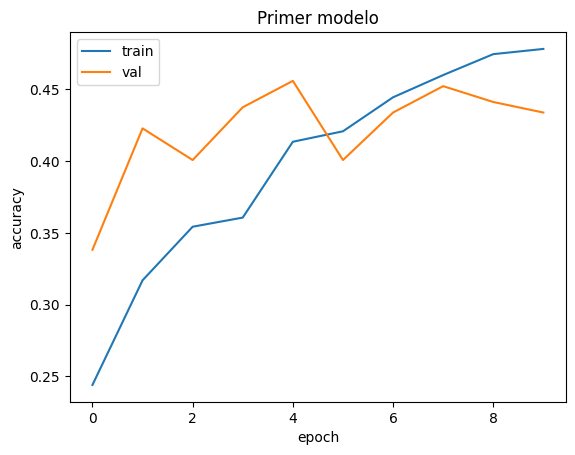

In [47]:
# Usamos matplotlib para graficar
from matplotlib import pyplot as plt

# Hacemos una gráfica para training y otra para val
plt.plot(model1_fit.history['accuracy'])
plt.plot(model1_fit.history['val_accuracy'])

# Definimos títulos y leyendas para la gráfica
plt.title('Primer modelo')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Mostramos la gráfica
plt.show()

Como podemos observar, la precisión del modelo no es igual o superior al 70% que se desea obtener, por lo que procedemos a realizar algunos ajustes al modelo. 


## Segundo modelo


Para mejorar el rendimiento de este modelo, se aplicarán las siguientes mejoras:

**Técnica de regularización: Data Augmentation.** 

Al tener un dataset pequeño, decido utilizar la técnica de Data Augmentation. Esto me permitirá generar nuevos ejemplares a través de modificaciones a imagenes existentes en el dataset.

**Capa de Dropout**

Ahora que tendremos una mayor cantidad de datos que se generaran a partir de una misma imagen, agregar una capa de dropout nos ayudará a evitar el overfitting causado por la memorización de las imagenes generadas que puedan ser muy similares entre sí. 

In [32]:
# Cantida de imagenes que serán procesadas en cada iteración del data generator
batch_size=16

# Defino un data generator que permita hacer data augmentation a través de distintas transformciones
datagen = ImageDataGenerator(
    # Se aplica un reescalado a las imágenes
    rescale=1/ 255,
    # Se invierten horizontalmente las imágenes
    horizontal_flip=True,
    # No se invierten verticalmente las imágenes
    vertical_flip=False,
    # Se define el formato en el que se guardan las imágenes generadas
    data_format="channels_last"
)

# Genero el dataset de train usando data augmentation a partir de la carpeta training
ds_train = datagen.flow_from_directory(
    'C:/Users/cutic/OneDrive/Escritorio/Tecnológico de Monterrey/Septimo semestre/DeepLearning/training',
    target_size=(255, 255),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="sparse",
    shuffle=True,
    seed=100,
)

# Genero el dataset de validation usando data augmentation a partir de la carpeta training
ds_valid = datagen.flow_from_directory(
    'C:/Users/cutic/OneDrive/Escritorio/Tecnológico de Monterrey/Septimo semestre/DeepLearning/validation',
    target_size=(255, 255),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="sparse",
    shuffle=True,
    seed=100,
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


Ahora vuelvo a crear el modelo de la misma forma, pero agregando la capa de dropout en la capa de salida

In [36]:
# Instanciamos Mobile Net v2
model = keras.applications.MobileNetV2(include_top=True)

# No utilizaremos el entrenamiento que viene por default en el modelo
model.trainable=False

# Definimos nuestros inputs como los mismos que trae el modelo
inputs=model.layers[0].input

# Conectamos nuestro nuevo output layer con todo nuestro modelo a excepción del output layer original
out=model.layers[-2].output

# Agrego una capa de dropout que ayudará a evitar el overfitting, eliminando neuronas que puedan estar memorizando el dataset
out=layers.Dropout(0.5)(out)

# Ahora agregamos una capa densa en la capa de output que nos interpretará las 10 clases existentes (tipos de macaquiño)
outputs=layers.Dense(10)(out)

# Instanciamos un nuevo modelo y lo llenamos con lo definido previamente 
final_model = keras.Model(inputs,outputs)

# Compilamos el modelo utilizando el optimizador Adam, así como una función de pérdida para funciones sparse categorical (multiples)
final_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
    metrics=["accuracy"],
)


KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_8'), name='input_8', description="created by layer 'input_8'") KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dense_6/BiasAdd:0', description="created by layer 'dense_6'")


In [37]:
# Entrenamos el nuevo modelo utilizando el dataset con data augmentation 
final_model_fit=final_model.fit(ds_train, epochs=10 , validation_data=ds_valid)

Epoch 1/10
69/69 [==============================] - 36s 493ms/step - loss: 1.3512 - accuracy: 0.5820 - val_loss: 0.4331 - val_accuracy: 0.9743
Epoch 2/10
69/69 [==============================] - 31s 450ms/step - loss: 0.3980 - accuracy: 0.9126 - val_loss: 0.2363 - val_accuracy: 0.9669
Epoch 3/10
69/69 [==============================] - 30s 427ms/step - loss: 0.2279 - accuracy: 0.9590 - val_loss: 0.1681 - val_accuracy: 0.9816
Epoch 4/10
69/69 [==============================] - 30s 432ms/step - loss: 0.1593 - accuracy: 0.9745 - val_loss: 0.1383 - val_accuracy: 0.9816
Epoch 5/10
69/69 [==============================] - 30s 437ms/step - loss: 0.1231 - accuracy: 0.9772 - val_loss: 0.1133 - val_accuracy: 0.9816
Epoch 6/10
69/69 [==============================] - 30s 428ms/step - loss: 0.1133 - accuracy: 0.9772 - val_loss: 0.1003 - val_accuracy: 0.9816
Epoch 7/10
69/69 [==============================] - 31s 451ms/step - loss: 0.0799 - accuracy: 0.9845 - val_loss: 0.1124 - val_accuracy: 0.9853

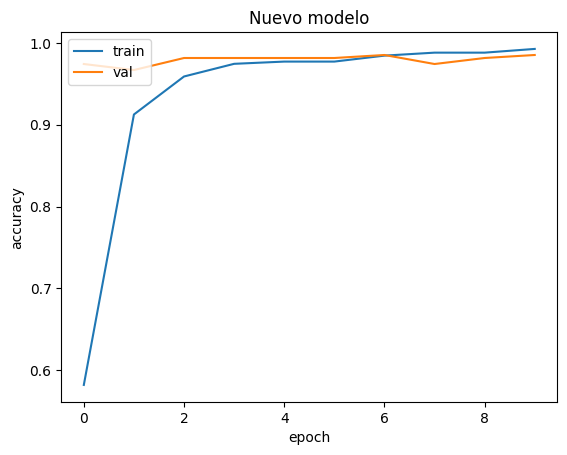

In [45]:
# Usamos matplotlib para graficar
from matplotlib import pyplot as plt

# Hacemos una gráfica para training y otra para val
plt.plot(final_model_fit.history['accuracy'])
plt.plot(final_model_fit.history['val_accuracy'])

# Definimos títulos y leyendas para la gráfica
plt.title('Nuevo modelo')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Mostramos la gráfica
plt.show()

Ahora vemos que en su última época el modelo llega a tener un accurracy de 0.99 en training y 0.98 en validation. Debido a que la diferencia entre estos dos es muy pequeña, descartamos un caso de overfitting. 

Este resultado cumple con nuestro objetivo inicial de precisión, por lo que podemos proceder a guardar el modelo para usarlo en un futuro.

In [39]:
# Nota del editor: el modelo se llama Makinator por la mezcla léxica de los vocablos "Macaco" y "Akinator".
final_model.save('makinator.h5')

¡Listo! Una vez que se ha guardado el modelo, es posible importarlo en otro código para hacer uso del mismo. 

Para ver una demostración del modelo, favor de revisar el archivo "demo.ipynb". 